# Initial Setup:

### 1. Install required packages

In [ ]:
%%capture
!pip install tensorflow_addons
!pip install albumentations
!pip install segmentation_models
!pip install keras
!sudo apt install zip unzip

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 2. Import needed modules

In [ ]:
%env SM_FRAMEWORK=tf.keras

env: SM_FRAMEWORK=tf.keras


In [ ]:
import os
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg 
import numpy as np 
import pandas as pd
import random

from PIL import Image

import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from functools import partial

from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
pritn

from keras import backend as keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ReduceLROnPlateau

from glob import glob

import albumentations as A
import tensorflow_addons as tfa

from segmentation_models import Unet
from segmentation_models.metrics import iou_score

import cv2 as cv2

### 3. Create the DatasetManager Class 
This class handles the reading, preprocessing, augmenting as well as displaying the data.

The get_dataset() method return a ready to use tensorflow dataset for training, validation and testing.

In [ ]:
class DatasetManager:
    def __init__(self, dataset_path, class_csv_file, bs = 10, augmentations = None):
        self.dataset_path = dataset_path
        self.class_csv_file = class_csv_file
        self._class_df = None
        self.label_dict = None
        self.batchsize = bs
        self.seed = 1
        self.dataset_dirname  = None
        self.dataset_raw = None
        self.buffer_size = 10000
        self.image_size = None
        self.dataset_img_filenames = None 
        self.transforms_image = None
        self.transforms_image_and_mask = None
        self._init_manager()

    def _init_manager(self):
        self._prepare_labeldict()
        if augmentations != None:
            self.transforms_image = augmentations["img_augmentation"]
            self.transforms_image_and_mask = augmentations["img_mask_augmentation"]

    def _prepare_labeldict(self):
        self._class_df = pd.read_csv(os.path.join(self.dataset_path, self.class_csv_file))
        colors = self._class_df[["r", "g", "b"]].values.tolist()
        colors = [tuple(color) for color in colors]
        category = self._class_df[["name"]].values.tolist()
        self.label_dict = {"COLORS": colors, "CATEGORIES": category}
    
    def show_label_encoding(self):
        return self._class_df
    
    def get_label_info(self):
        return self.label_dict
    
    def _augment_data(self, datapoint): 
        input_image = datapoint['image']
        input_mask = datapoint['segmentation_mask']
        return input_image, input_mask

    def _process_data(self, image_path, mask_path):
        image, mask = self._get_image(image_path), self._get_image(mask_path, mask=True)
        if self.dataset_dirname == "train":
            aug_img = tf.numpy_function(func=self._aug_training, inp=[image, mask], Tout=(tf.float32,tf.float32))
            datapoint = self._normalize_img_and_colorcorrect_mask(aug_img[0],aug_img[1])
            return datapoint[0], datapoint[1]
        else:
            aug_img = tf.numpy_function(func=self._aug_basic, inp=[image, mask], Tout=(tf.float32,tf.float32))
            datapoint = self._normalize_img_and_colorcorrect_mask(aug_img[0],aug_img[1])
            return datapoint[0], datapoint[1]

    def _get_filenpaths(self): 
        dataset_img_filenames = tf.data.Dataset.list_files(self.dataset_path + self.dataset_dirname+"/"+ "*.png", seed=self.seed)
        image_paths = os.path.join(self.dataset_path,self.dataset_dirname, "*")
        mask_paths = os.path.join(self.dataset_path,self.dataset_dirname+"_labels", "*")
        image_list = sorted(glob(image_paths))
        mask_list = sorted(glob(mask_paths))
        return image_list, mask_list     

    def _get_image(self, image_path,  mask=False):
        img = tf.io.read_file(image_path)
        if not mask:
            img = tf.cast(tf.image.decode_png(img, channels=3), dtype=tf.float32)
        else:
            img = tf.cast(tf.image.decode_png(img, channels=3), dtype=tf.float32)
        return img

    def _aug_training(self,image, mask):
        # augment image and mask
        img_mask_data = {"image":image, "mask":mask}
        aug_image_and_mask = self.transforms_image_and_mask(**img_mask_data)
        aug_img = aug_image_and_mask["image"]
        aug_mask = aug_image_and_mask["mask"]
        # augment image only
        img_data = {"image":aug_img}
        aug_data =  self.transforms_image(**img_data)
        aug_img = aug_data["image"]

        aug_img = tf.cast(aug_img, tf.float32)
        aug_img = tf.image.resize(aug_img, size=self.image_size)
        aug_mask = tf.cast(aug_mask, tf.float32)
        aug_mask = tf.image.resize(aug_mask, size=self.image_size)
        aug_img = tf.clip_by_value(aug_img, 0,255)
        return (aug_img, aug_mask)
    
    def _aug_basic(self,image, mask):
        aug_img = tf.cast(image, tf.float32)
        aug_img = tf.image.resize(aug_img, size=self.image_size)
        aug_mask = tf.cast(mask, tf.float32)
        aug_mask = tf.image.resize(aug_mask, size=self.image_size)
        return (aug_img, aug_mask)

    def _normalize_img_and_colorcorrect_mask(self,input_image, input_mask): 
        input_image = tf.cast(input_image, tf.float32) / 255.0
        one_hot_map = []
        for color in self.label_dict["COLORS"]:
            class_map = tf.reduce_all(tf.equal(input_mask, color), axis=-1)
            one_hot_map.append(class_map)
        one_hot_map = tf.stack(one_hot_map, axis=-1)
        one_hot_map = tf.cast(one_hot_map, tf.float32)
        return (input_image, one_hot_map)
        
    @tf.function    
    def _set_shapes(self, img, mask):  
        img.set_shape((self.image_size[0],self.image_size[1],3))
        mask.set_shape((self.image_size[0],self.image_size[1],32))
        return img,mask
    
    def _restore_original_mask_colors(self, mask):
        new_mask = mask
        h,w = new_mask.shape 
        new_mask = np.reshape(new_mask, (h*w,1))
        dummy_mask = np.ndarray(shape=(h,w, 3))
        dummy_mask =  np.reshape(dummy_mask, (h*w, 3))
        for idx, pixel in enumerate(new_mask):
            dummy_mask[idx] = np.asarray(data_manager.label_dict["COLORS"][int(pixel)])
        return np.reshape(dummy_mask, (h,w,3))/255.
    
    def _get_prepared_dataset(self):
        if self.dataset_dirname == "train":
            self.dataset = self.dataset.map(self._process_data, num_parallel_calls=self.AUTOTUNE).prefetch(self.AUTOTUNE)
            self.dataset = self.dataset.map(self._set_shapes, num_parallel_calls=self.AUTOTUNE).shuffle(150).repeat().batch(self.batchsize ).prefetch(self.AUTOTUNE)
            self.train_ds = self.dataset
            return self.train_ds
        elif self.dataset_dirname == "val":
            self.dataset = self.dataset.map(self._process_data, num_parallel_calls=self.AUTOTUNE).prefetch(self.AUTOTUNE)
            self.dataset = self.dataset.map(self._set_shapes, num_parallel_calls=self.AUTOTUNE).repeat().batch(self.batchsize ).prefetch(self.AUTOTUNE)
            self.val_ds = self.dataset
            return self.val_ds
        elif self.dataset_dirname == "test":
            self.dataset = self.dataset.map(self._process_data, num_parallel_calls=self.AUTOTUNE).prefetch(self.AUTOTUNE)
            self.dataset = self.dataset.map(self._set_shapes, num_parallel_calls=self.AUTOTUNE).repeat().batch(1).prefetch(self.AUTOTUNE)
            self.test_ds = self.dataset
            return self.test_ds

    def show_batch(self, ds, fsize = (15,5)):
        image_batch, label_batch = next(iter(ds)) 
        image_batch = image_batch.numpy()
        label_batch = label_batch.numpy()
        for i in range(len(image_batch)):
            fig, (ax1, ax2 )= plt.subplots(1, 2, figsize=fsize)
            fig.suptitle('Image Label')
            ax1.imshow(image_batch[i])
            ax2.imshow(self._restore_original_mask_colors(np.argmax(label_batch[i], axis=-1)))

    def get_dataset(self, dataset_dirname, image_size = (128,128)): 
        self.AUTOTUNE = tf.data.experimental.AUTOTUNE
        self.image_size = image_size 
        self.dataset_dirname = dataset_dirname
        self.image_list, self.mask_list  = self._get_filenpaths()
        self.dataset = tf.data.Dataset.from_tensor_slices((self.image_list, self.mask_list))
        return self._get_prepared_dataset()

# Training Preperation:

In [ ]:
DATA_PATH = "/content/drive/MyDrive/Datasets/CamVid/"
CLASS_CSV_FILENAME = "class_dict.csv"
BATCH_SIZE = 8
NUM_PIXELS_SQRT  = 32*8 #Resnet expects integer multiplies of 32
IM_SIZE = (NUM_PIXELS_SQRT, NUM_PIXELS_SQRT)
OUTPUT_CHANNELS = 32

## 1. Prepare augmentations
Due to the low amount of data (369 train images) and the complexity of the task (Semantic Segmentation) we use data augmentation to improve performance. Keep in mind that certain augmentations such as rotation and flipping must be applied to the images as well as corresponding masks. However, other augmentations like changing the brightness or contrast must only be applied to the images.

In [ ]:
image_mask_augmentations = A.Compose([A.Rotate(limit=20),
                                      A.HorizontalFlip(p=0.3),
                                      A.Resize(NUM_PIXELS_SQRT, NUM_PIXELS_SQRT, interpolation= cv2.INTER_NEAREST, p = 1),
                                      A.RandomSizedCrop(min_max_height=(int(NUM_PIXELS_SQRT*0.5), int(NUM_PIXELS_SQRT*1)), 
                                                        height=NUM_PIXELS_SQRT, width=NUM_PIXELS_SQRT, p=0.8),
                                      ])

image_augmentation =  A.Compose([A.RandomGamma(p=0.8)])

augmentations = {"img_augmentation": image_augmentation, "img_mask_augmentation": image_mask_augmentations}

## 2. Get the datasets by instantiating a DatasetManager object and calling get_dataset() 

In [ ]:
data_manager = DatasetManager(DATA_PATH, CLASS_CSV_FILENAME, BATCH_SIZE, augmentations = augmentations)

train_ds = data_manager.get_dataset("train",  image_size = IM_SIZE) 
val_ds = data_manager.get_dataset("val", image_size = IM_SIZE) 
test_ds = data_manager.get_dataset("test", image_size = IM_SIZE) 

## 3. (Optional) Investigate augmentation result samples.
Hint: Augmentation is only performed on the train_ds

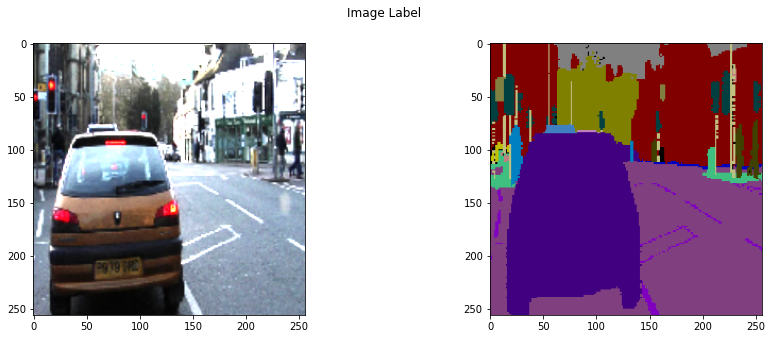

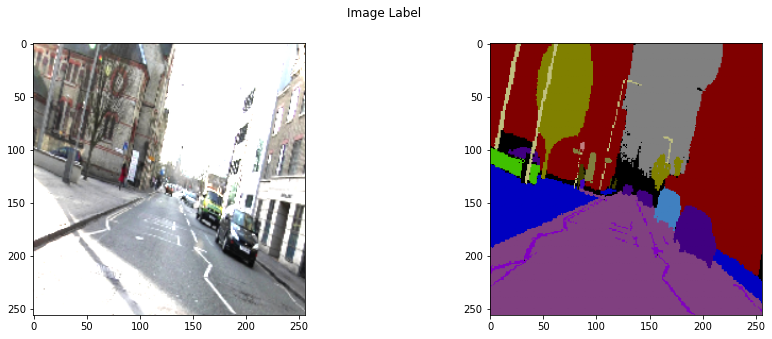

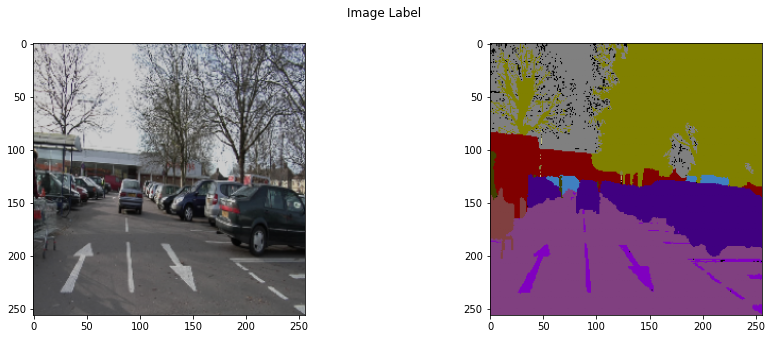

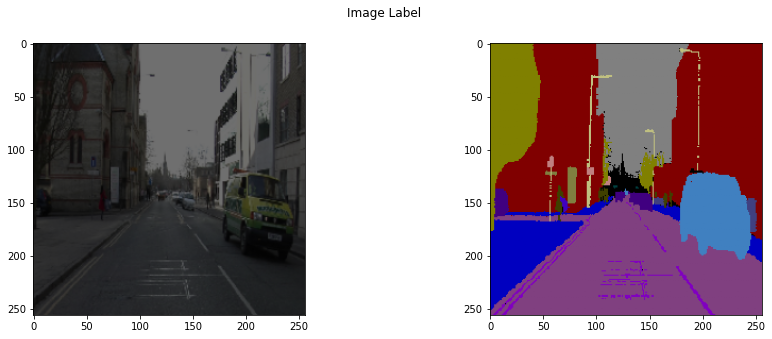

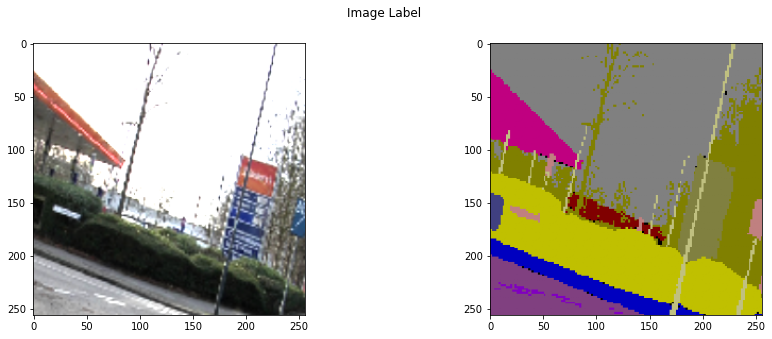

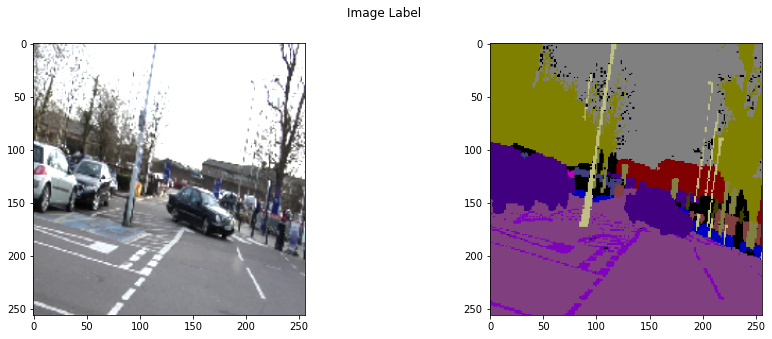

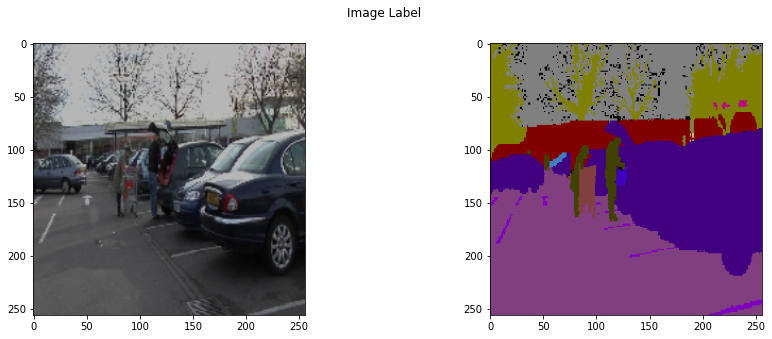

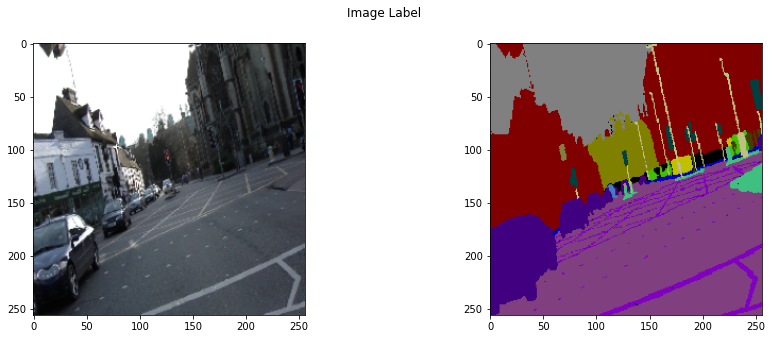

In [ ]:
 data_manager.show_batch(train_ds)

## 4. Prepare the model
We use a standard UNet architecture with a Resnet101 backbone pretrained on imagenet.

Currently the following architectures are supported:
- Unet
- FPN
- Linknet
- PSPNet

Feel free to try different backbones:
- resnet18, resnet34, resnet50, resnet101, resnet152 
- seresnet18, seresnet34, seresnet50, seresnet101, seresnet152,seresnext50, seresnext101, senet154
- resnext50, resnext101 
- vgg16, vgg19 
- densenet121, densenet169, densenet201 
- inceptionresnetv2, inceptionv3 
- mobilenet, mobilenetv2 
- efficientnetb0, efficientnetb1, efficientnetb2, efficientnetb3, efficientnetb4, efficientnetb5, efficientnetb6, efficientnetb7


In [ ]:
def compute_metrics(y_true, y_pred):
  class_wise_iou = []
  class_wise_dice_score = []

  smoothening_factor = 0.00001

  for i in range(32):
    intersection = np.sum((y_pred == i) * (y_true == i))
    y_true_area = np.sum((y_true == i))
    y_pred_area = np.sum((y_pred == i))
    combined_area = y_true_area + y_pred_area
    
    if intersection == 0 and combined_area == 0:
      iou = 0.0
    else: 
      iou = (intersection + smoothening_factor) / (combined_area - intersection + smoothening_factor)
    class_wise_iou.append(iou)
    
    dice_score =  2 * ((intersection + smoothening_factor) / (combined_area + smoothening_factor))
    class_wise_dice_score.append(dice_score)

  return class_wise_iou, class_wise_dice_score

In [ ]:
base_model = Unet(backbone_name='resnet101', encoder_weights='imagenet', encoder_freeze=True, activation="softmax", classes =32)
model = base_model

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9, nesterov=True), loss="categorical_crossentropy", metrics=["accuracy"])

## 4. Train the model

In [ ]:
rl = ReduceLROnPlateau(monitor='val_accuracy',factor=0.1, patience=8,verbose=1,mode="max",min_lr=0.0001)

EPOCHS = 120
STEPS_PER_EPOCH =369//BATCH_SIZE
VALIDATION_STEPS = 100 // BATCH_SIZE

model_history = model.fit(train_ds, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=val_ds, callbacks=[rl])

Epoch 1/120
46/46 [==============================] - 37s 511ms/step - loss: 2.0419 - accuracy: 0.4487 - val_loss: 2424.1433 - val_accuracy: 0.1617
Epoch 2/120
46/46 [==============================] - 22s 473ms/step - loss: 1.0656 - accuracy: 0.7088 - val_loss: 22.2903 - val_accuracy: 0.1428
Epoch 3/120
46/46 [==============================] - 21s 471ms/step - loss: 0.9881 - accuracy: 0.7244 - val_loss: 3.4943 - val_accuracy: 0.2982
Epoch 4/120
46/46 [==============================] - 22s 474ms/step - loss: 0.9157 - accuracy: 0.7413 - val_loss: 9.7836 - val_accuracy: 0.1641
Epoch 5/120
46/46 [==============================] - 22s 479ms/step - loss: 0.8365 - accuracy: 0.7651 - val_loss: 11.6481 - val_accuracy: 0.1707
Epoch 6/120
46/46 [==============================] - 22s 482ms/step - loss: 0.8056 - accuracy: 0.7704 - val_loss: 5.1337 - val_accuracy: 0.3916
Epoch 7/120
46/46 [==============================] - 22s 478ms/step - loss: 0.7917 - accuracy: 0.7762 - val_loss: 4.6933 - val_accu

# End

## Utility functions for upsampling and color correction

In [ ]:
def upsample_img(img, size = (720,960)):
  upsampled_img = tf.image.resize(img, size, antialias=True, method=tf.image.ResizeMethod.BILINEAR)  
  return upsampled_img

def upsample_mask(mask, size = (720,960)):
  upsampled_mask = np.argmax(mask, axis= -1)
  upsampled_mask = tf.image.resize(np.expand_dims(upsampled_mask,-1), size, antialias=True, method=tf.image.ResizeMethod.BILINEAR)  
  return reset_original_mask_colors(np.squeeze(upsampled_mask))

def reset_original_mask_colors(mask):
  h,w = mask.shape 
  new_mask = np.reshape(mask, (h*w, 1))
  dummy_mask = np.ndarray(shape=(h*w, 3))

  for idx, pixel in enumerate(new_mask):
    dummy_mask[idx] = np.asarray(data_manager.label_dict["COLORS"][int(pixel)])
  return np.reshape(dummy_mask, (h,w,3))/255

### Create directory for storing inference images

In [ ]:
!mkdir test_results

mkdir: cannot create directory ‘test_results’: File exists


In [ ]:
from operator import add

In [ ]:
TEST_STEPS = 232 
num_test_imgs = 232 
results = model.predict(data_manager.test_ds, batch_size = 1, steps = TEST_STEPS)

batch_images = None
batch_masks = None
img_cnt = 0

for img,mask in data_manager.test_ds.take(num_test_imgs): #16
  batch_images=img
  batch_masks=mask
  batch_result = model.predict(batch_images)
  for result in batch_result:
    img_cnt +=1
    upsampled_test = upsample_mask(result)
    im = Image.fromarray((upsampled_test * 255).astype(np.uint8))
    filename = "/content/test_results/number"+str(img_cnt)+".jpeg"
    im.save(filename)

### Zip Inference directory for easier download

In [ ]:
%%capture
!zip -r test_results.zip test_results

## Sample prediction

In [ ]:
batch_result = model.predict(batch_images)

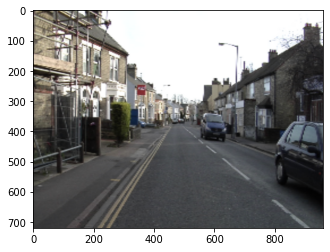

In [ ]:
plt.imshow(upsample_img(batch_images[0]))

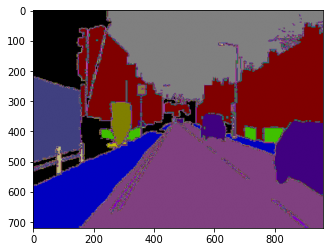

In [ ]:
plt.imshow(upsample_mask(batch_masks[0]))

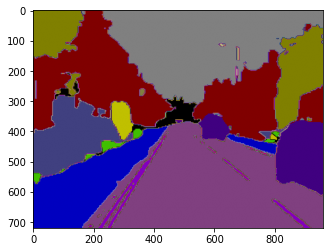

In [ ]:
plt.imshow(upsample_mask(batch_result[0]))